# Fraudes em cartão de crédito como um exemplo de dados desbalanceados

                        Equipe:
                        - Lucas de Sousa Brito                            

# 1. Introdução

Este notebook trata da criação de um modelo de detecção de fraudes em uma base pública de cartões de crédito que serve como um exemplo do tratamento de *conjuntos de dados desbalanceados*. A base em questão contém cerca de 280 mil transações, das quais apenas 492 são fraude. 

> The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions (https://www.kaggle.com/mlg-ulb/creditcardfraud)

Este é um problema interessante por dois motivos:
* Indicadores de Acurácia e F1 apresentam resultados bons, mesmo quando o modelo é ruim. 
* Modelos de aprendizado supervisionado não convergem bem se o conjunto de dados é desbalanceado. 

Para tratar este problema foram adotadas as seguintes estratégias:
* Foram adotados indicadores de Sensitividade (percentual da fraude total identificada pelo modelo) e Precisão (percentual das fraudes previstas que eram efetivamente fraude)
* No conjunto de treinamento, foram tomadas 50 mil transações, sendo 25 oriundas da base de fraudes, 25 mil da base de não fraudes. Como existem apenas 492 fraudes, naturalmente que tem um grande volume de repetições na base de treino.
* No conjunto de testes não houve balanceamento para não afetar os índices de desempenho do modelo. 

O modelo utilizado foi um "Stacking" de:
* Regressão Logística
* Máquina de Vetores de Suporte
* Árvore de Decisão
que usa uma Rede Neural para integrar os scores destas três. 

# 2. Carga e preparação do conjunto de dados

Segundo os [autores do dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud), o dataset é composto de: 
* data/hora em segundos a partir do início da coleta de dados;
* V1 a V28 são as features da transação exceto pelo tempo e valor codificadas através de uma transformação [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) usada para preservar a privacidade dos clientes. O leiaute [ISO8583](https://en.wikipedia.org/wiki/ISO_8583) é amplamente usado no mercado financeiro para transações de cartões de débito e crédito e ilustra alguns tipos de dados que devem ter sido a origem dos dados consultados. Atributos como conta, loja, tipo de loja, endereço da loja, tipo de senha e cartão utilizados, situação do terminal e etc. Como o PCA mistura estes atributos não é possível identificar a participação de cada um e a as distribuições dos atributos não teriam muito significado. 
* valor em dólares
* classe (0=não fraude; 1=fraude)


A base de dados é um CSV bem formatado, forma efetuadas apenas as seguintes alterações:
* adicionada colunas wday (dia da semana), dia (do mês), hora (do dia) e segundo (da hora);
* adicionada colunas com faixas de valores;
* adicionada coluna com o valor padronizado (valor-média)/desvio_padrao

Abaixo segue uma amostra do arquivo:

In [1]:
def block():
    
    global df
        
    import numpy as np 
    import pandas as pd 
    import os.path
    pd.options.display.max_columns = None
    
    if os.path.isfile('/kaggle/input/creditcardfraud/creditcard.csv'):
        df = pd.read_csv( '/kaggle/input/creditcardfraud/creditcard.csv' )
    elif os.path.isfile( 'data/creditcard.csv' ):
        df = pd.read_csv( 'data/creditcard.csv' )
    else:
        raise Exception('Por favor, inclua o arquivo de dados em data/creditcard.csv')
        
    df_len = len(df)
    
    df = df.rename(columns={'Time':'dt'})
    df = df.rename(columns={'Amount':'vr'})

    df.insert( 1, 'dt_sec', df['dt'].apply( lambda x: int(x%(60*60) ) ) )
    df.insert( 1, 'dt_hour', df['dt'].apply( lambda x: int(x%(24*60*60)/(60*60) ) ) )
    df.insert( 2, 'dt_wday', ( df['dt'].apply( lambda x: int(x/(24*60*60)%7) ) ) ) 
    df['dt'] = df['dt'].apply( lambda x: int(x/(24*60*60)) )
    df = df.rename(columns={'dt':'dt_day'})
        
    df['vr_f1'] = df['vr'].apply( lambda x: 1 if x < 10 else 0 )
    df['vr_f2'] = df['vr'].apply( lambda x: 1 if 10 < x < 20 else 0 )
    df['vr_f3'] = df['vr'].apply( lambda x: 1 if 20 < x < 50 else 0 )
    df['vr_f4'] = df['vr'].apply( lambda x: 1 if 50 < x < 100 else 0 )
    df['vr_f5'] = df['vr'].apply( lambda x: 1 if 100 < x < 200 else 0 )
    df['vr_f6'] = df['vr'].apply( lambda x: 1 if 200 < x < 500 else 0 )
    df['vr_f7'] = df['vr'].apply( lambda x: 1 if 500 < x < 1000 else 0 )
    df['vr_f8'] = df['vr'].apply( lambda x: 1 if 1000 < x < 1500 else 0 )
    df['vr_f9'] = df['vr'].apply( lambda x: 1 if 1500 < x < 2000 else 0 )
    df['vr_f10'] = df['vr'].apply( lambda x: 1 if 2000 < x < 2500 else 0 )
    df['vr_f11'] = df['vr'].apply( lambda x: 1 if 2500 < x < 5000 else 0 )
    df['vr_f12'] = df['vr'].apply( lambda x: 1 if 5000 < x else 0 )
    
    df['vr_pad'] = ( df['vr'] - df['vr'].mean() ) / df['vr'].std()       

    assert df_len==len(df), "ERROR, the source dataset was unexpectedly modified"
    
    print( "OK, Dataset loaded" )
    
    return df
      
block()

OK, Dataset loaded


,dt_day,dt_hour,dt_wday,dt_sec,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,vr,Class,vr_f1,vr_f2,vr_f3,vr_f4,vr_f5,vr_f6,vr_f7,vr_f8,vr_f9,vr_f10,vr_f11,vr_f12,vr_pad
0,0,0,0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0,0,0,0,1,0,0,0,0,0,0,0,0.244964
1,0,0,0,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.342474
2,0,0,0,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0,0,0,0,0,1,0,0,0,0,0,0,1.160684
3,0,0,0,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0,0,0,0,1,0,0,0,0,0,0,0,0.140534
4,0,0,0,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.073403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,1,23,1,3586,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,1,0,0,0,0,0,0,0,0,0,0,0,-0.350150
284803,1,23,1,3587,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.254116
284804,1,23,1,3588,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,0,0,0,1,0,0,0,0,0,0,0,0,-0.081839
284805,1,23,1,3588,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.313248


In [3]:
def block():
    
    u = df.describe().transpose()
    
    u['Types'] = df.dtypes
    u['Distinct Values'] = df.nunique()    
    u['%Distinct Values'] = df.nunique() / len(df) * 100.0
    
    return u.transpose()
    
block()

,dt_day,dt_hour,dt_wday,dt_sec,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,vr,Class,vr_f1,vr_f2,vr_f3,vr_f4,vr_f5,vr_f6,vr_f7,vr_f8,vr_f9,vr_f10,vr_f11,vr_f12,vr_pad
count,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0
mean,0.491635,14.04647,0.491635,1769.330473,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,88.349619,0.001727,0.341684,0.129435,0.177573,0.127725,0.095479,0.067923,0.021323,0.005583,0.002258,0.000797,0.001352,0.000193,0.0
std,0.499931,5.835854,0.499931,1045.771276,1.958696,1.651309,1.516255,1.415869,1.380247,1.332271,1.237094,1.194353,1.098632,1.08885,1.020713,0.999201,0.995274,0.958596,0.915316,0.876253,0.849337,0.838176,0.814041,0.770925,0.734524,0.725702,0.62446,0.605647,0.521278,0.482227,0.403632,0.330083,250.120109,0.041527,0.474275,0.335681,0.382153,0.333784,0.293876,0.251614,0.14446,0.074509,0.047461,0.028221,0.036742,0.013895,1.0
min,0.0,0.0,0.0,0.0,-56.40751,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.49772,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.353229
25%,0.0,10.0,0.0,857.0,-0.920373,-0.59855,-0.890365,-0.84864,-0.691597,-0.768296,-0.554076,-0.20863,-0.643098,-0.535426,-0.762494,-0.405571,-0.648539,-0.425574,-0.582884,-0.468037,-0.483748,-0.49885,-0.456299,-0.211721,-0.228395,-0.54235,-0.161846,-0.354586,-0.317145,-0.326984,-0.07084,-0.05296,5.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.33084
50%,0.0,15.0,0.0,1764.0,0.018109,0.065486,0.179846,-0.019847,-0.054336,-0.274187,0.040103,0.022358,-0.051429,-0.092917,-0.032757,0.140033,-0.013568,0.050601,0.048072,0.066413,-0.065676,-0.003636,0.003735,-0.062481,-0.02945,0.006782,-0.011193,0.040976,0.016594,-0.052139,0.001342,0.011244,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.265271
75%,1.0,19.0,1.0,2673.0,1.315642,0.803724,1.027196,0.743341,0.611926,0.398565,0.570436,0.327346,0.597139,0.453923,0.739593,0.618238,0.662505,0.49315,0.648821,0.523296,0.399675,0.500807,0.458949,0.133041,0.186377,0.528554,0.147642,0.439527,0.350716,0.240952,0.091045,0.07828,77.165,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.044717
max,1.0,23.0,1.0,3599.0,2.45493,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.50309,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.16,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,102.362063
Types,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64
Distinct Values,2,24,2,3600,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,275663,32767,2,2,2,2,2,2,2,2,2,2,2,2,2,32767


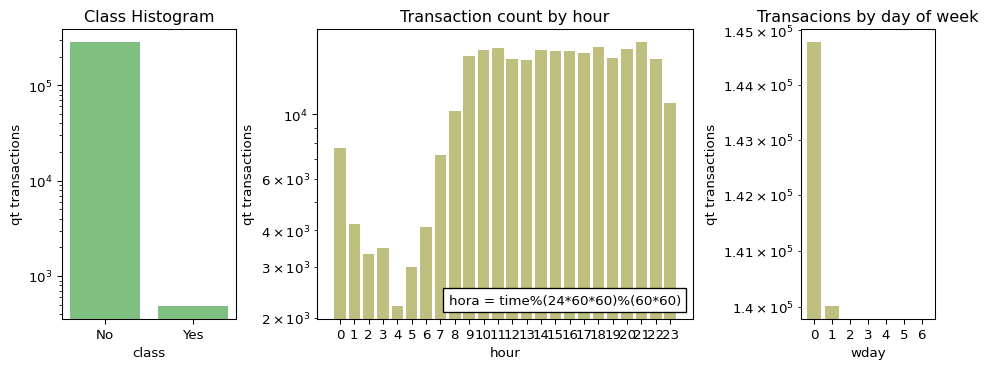

In [5]:
def block():

    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np
    %matplotlib inline
        
    fig = plt.figure(figsize=(13,4), dpi=96)
    fig_grid = fig.add_gridspec(100,360)

    ax = fig.add_subplot( fig_grid[ 0:100, 15:80 ] )
    ax.set( title="Class Histogram", 
            xlabel="class", xticks=[0,1], xticklabels=['No', 'Yes'],
            ylabel="qt transactions",  yscale="log" )
    ax.hist( df['Class'] , [x for i in range(2) for x in (i-0.4,i+0.4)], color='#00800080')
    
    ax_cols = [x for x in range(0,24)]
    ax = fig.add_subplot( fig_grid[ 0:100, 110:250 ] )
    ax.set( title="Transaction count by hour",
            xlabel='hour', xticks=ax_cols, xticklabels=ax_cols, 
            ylabel='qt transactions', yscale='log' )
    ax.hist( df['dt_hour'] , [x for i in ax_cols for x in (i-0.4,i+0.4)], color='#80800080')
    ax.add_artist(matplotlib.offsetbox.AnchoredText("hora = time%(24*60*60)%(60*60)", frameon=True, loc='lower right'))
    
    ax_cols = [x for x in range(0,7)]
    ax = fig.add_subplot( fig_grid[ 0:100, 290:340 ] )
    ax.set( title="Transacions by day of week",
            xlabel='wday', xticks=ax_cols, xticklabels=ax_cols,
            ylabel='qt transactions', yscale='log')
    ax.hist( df['dt_wday'] , [x for i in ax_cols for x in (i-0.4,i+0.4)], color='#80800080')
    
    plt.show()

block()

# 3. Preparação dos dados para o modelo

O código a seguir:
* Divide o conjunto de dados em dois:
  * **train** com 80% dos registros;
  * **test** com 20% dos registros.
* Balanceia o conjunto de treinamento. A técnica usada foi escolher 50 mil elementos de fraude e 50 mil elementos de não fraude aleatoriamente com reposição.
* Define as "features" que serão usadas no treinamento.

In [33]:
def block():
    
    global df
    global X_train, X_test, X_validation
    global Y_train, Y_test, Y_validation    
    global df_features
    
    df_features = [
         'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9','V10',
        'V11','V12','V13','V14','V15','V16','V17','V18','V19','V20',
        'V21','V22','V23','V24','V25','V26','V27','V28',
        'vr_pad'
        #,  'vr_f1','vr_f2','vr_f3', 'vr_f4', 'vr_f5', 'vr_f6',
        #'vr_f7','vr_f8','vr_f9','vr_f10','vr_f11','vr_f12'       
    ]
    
    from sklearn.model_selection import train_test_split
            
    # first split (df into train and test)
    X_train, X_test = train_test_split(df, test_size=0.2, stratify=df['Class'], random_state=564654)
    
    # second split (tain into test and validation)
    # X_train, X_validation = train_test_split(X_train, test_size=0.2, stratify=X_train['Class'])
      
    # ballance classes    
    X_train_fraude = X_train[ X_train['Class'] == 1 ]
    X_train_naofraude = X_train[ X_train['Class'] == 0 ]
    
    sample_size = 50000
    X_train = X_train_fraude.sample(n=sample_size,random_state=564654, replace=True )
    X_train = X_train.append( X_train_naofraude.sample(n=sample_size,random_state=564654, replace=True ) )
       
    # third split: (classes)
    Y_train = X_train.pop( 'Class' )
    Y_test = X_test.pop( 'Class' )
    #y_validation = X_validation.pop( 'Class')
        
    print(f'Training shape: {X_train.shape} {Y_train.shape}' )
    #print(f'Validation shape: {X_validation.shape} {y_validation.shape}' )
    print(f'Test shape: {X_test.shape} {Y_test.shape}' )
         
block()

Training shape: (100000, 46) (100000,)
Test shape: (56962, 46) (56962,)


# 4. Configura o modelo e treina

Neste exemplo será usada a técnica de "Stacking" que funciona da seguinte forma:

      camada 1                camada 2

      [modelo a1] ----+ 
                      |
      [modelo a2] ----+----> [modelo f] ---> resultado
                      |
      [modelo a3] ----+
                      
         (...)

O resultado de um conjunto de modelos (camada 1) são usados como entrada de outro modelo (camada 2). 

In [34]:
def block():
    
    global model
    
    import sklearn.neural_network 
    import sklearn.model_selection
    import sklearn.ensemble
    import sklearn.naive_bayes
    import sklearn.svm
    import sklearn.tree    
    import pandas as pd 
        
    model = sklearn.ensemble.StackingClassifier( 
        [
            (
                "m1",
                sklearn.linear_model.LogisticRegression(
                    random_state=564654
                )
            ),
            (
                "m2",
                sklearn.tree.DecisionTreeClassifier(
                    random_state=564654
                )
            ),
            (
                "m3",
                sklearn.linear_model.RidgeClassifier(   
                    random_state=564654
                )                                    
                #sklearn.tree.DecisionTreeClassifier(
                #    random_state=564654
                #)                
                #sklearn.svm.SVC(
                #    probability=True,
                #    kernel='linear',
                #    random_state=564654
                #)
            )
        ], 
        final_estimator=sklearn.neural_network.MLPClassifier(
            solver='adam',            #default='adam'
            learning_rate_init=0.001, #default=0.001 step size when updating weights
            alpha=0.0001,             #default=0.0001 
            hidden_layer_sizes=(8,8), 
            random_state=564654,
            activation='relu',        #default='relu'
            max_iter=100,
            early_stopping=True,
            verbose=True
        ),
        passthrough=False,
        cv=2,
        n_jobs=4
    )        
    
    model.fit( X_train[ df_features ], Y_train )          
          
block()

Iteration 1, loss = 0.43065902
Validation score: 0.998400
Iteration 2, loss = 0.03518518
Validation score: 0.998800
Iteration 3, loss = 0.01346564
Validation score: 0.998800
Iteration 4, loss = 0.00854507
Validation score: 0.998800
Iteration 5, loss = 0.00802016
Validation score: 0.998800
Iteration 6, loss = 0.00786978
Validation score: 0.998800
Iteration 7, loss = 0.00781790
Validation score: 0.998800
Iteration 8, loss = 0.00779835
Validation score: 0.998800
Iteration 9, loss = 0.00776652
Validation score: 0.998800
Iteration 10, loss = 0.00775286
Validation score: 0.998800
Iteration 11, loss = 0.00773925
Validation score: 0.998800
Iteration 12, loss = 0.00773892
Validation score: 0.998800
Iteration 13, loss = 0.00771029
Validation score: 0.998800
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


# 5. Avaliação dos resultados

Na [matriz de confusão][2] (abaixo):
* A diagonal verde representa as previsões corretas feitas pelo modelo;
* A diagonal vermelha representa as previsões incorretas feita pelo modelo;

Neste tipo de problema o objetivo é detectar o máximo de *verdadeiros positivos* (tp) com um mínimo de *falsos negativos* (fn) e um mínimo de *falsos positivos* (fp). Para refletir isto foi selecionado o seguinte conjunto de indicadores:
* **[Sensitividade][1] (True Positive Rate or Recall)** = `tp / (tp+fn)`
* **[Precisão][1] (Positive Predictive Value)** = `tp / (tp+fp)`.

Neste tipo de problema, é comum que a *[Acurácia][3]* (`(tp+tn/tp+tn+fp+fn)` ) apresente resultados próximos a 100% mesmo quando o modelo não tenha um bom poder preditivo. Um simples *experimento mental* pode ilustrar isto: um modelo que alerte apenas classe=0 com os mesmos dados da matriz de confusão abaixo teria uma acurácia de 99,82%, mesmo sem ter valor preditivo. O *F-Score* é a média harmônica da *Acurácia* e do *Recall*, portanto herda parte da distorção da *Acurácia*. É importante ressaltar que estas limitações são particulares ao tipo de problema que está sendo avaliado e portanto não devem ser tomadas como regra geral.

[1]: https://en.wikipedia.org/wiki/Precision_and_recall
[2]: https://en.wikipedia.org/wiki/Confusion_matrix
[3]: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9?gi=ddfdb7bbd07f

Relatório de classificação para o conjunto de treinamento
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50000
           1       1.00      1.00      1.00     50000

    accuracy                           1.00    100000
   macro avg       1.00      1.00      1.00    100000
weighted avg       1.00      1.00      1.00    100000

Relatório de classificação para o conjunto de testes
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.41      0.79      0.53        98

    accuracy                           1.00     56962
   macro avg       0.70      0.89      0.77     56962
weighted avg       1.00      1.00      1.00     56962



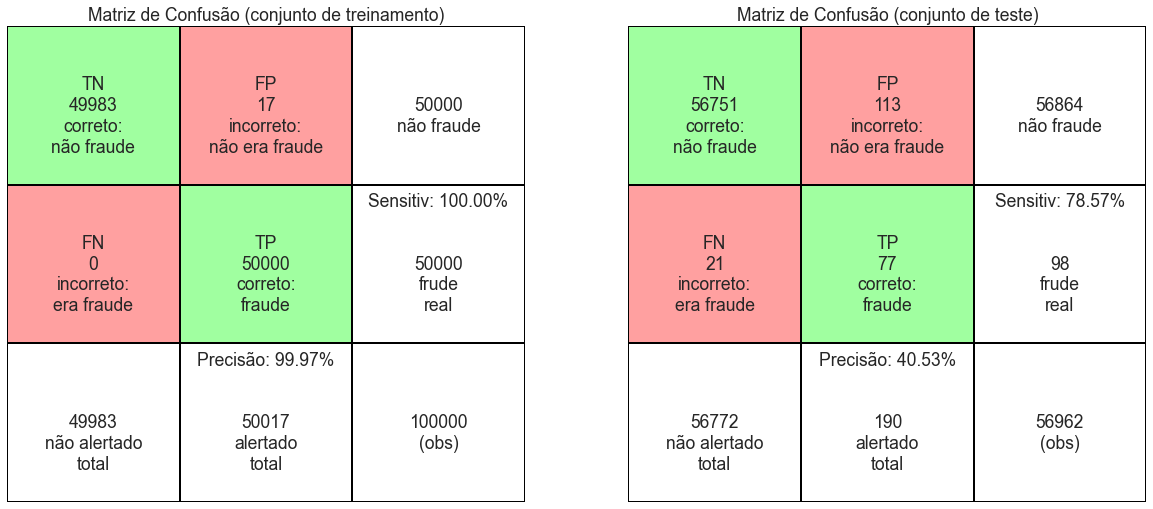

In [35]:
def bloco():
    
    import matplotlib
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    #from sklearn.metrics import roc_curve
    import seaborn as sns
    import pandas as pd
    
    Y_test_pred = model.predict( X_test[ df_features ] )
    Y_train_pred = model.predict( X_train[ df_features ] )

    from sklearn.metrics import classification_report
    
    print( 'Relatório de classificação para o conjunto de treinamento')
    print( classification_report( Y_train, Y_train_pred ) )
    
    print( 'Relatório de classificação para o conjunto de testes')
    print( classification_report( Y_test, Y_test_pred ) )      

    def matriz_confusao( fig, ax, Y, Y_pred, title ):
        
        class_names = ['Fraude','Não Fraude']

        confusion_mtx = pd.DataFrame( 
            columns=class_names,        
            data=confusion_matrix( Y, Y_pred )
        )    
        confusion_mtx['Total'] = confusion_mtx['Não Fraude'] + confusion_mtx['Fraude']
        confusion_mtx = confusion_mtx.append(confusion_mtx.sum(numeric_only=True), ignore_index=True)
        confusion_mtx = confusion_mtx.rename( index={ 0:'Não Fraude', 1:'Fraude', 2:'Total' } )

        fp = confusion_mtx.iloc[0,1] 
        fn = confusion_mtx.iloc[1,0]
        tn = confusion_mtx.iloc[0,0]
        tp = confusion_mtx.iloc[1,1] 

        acc       = (tp+tn)/(tp+tn+fp+fn)
        recall    = tp/(tp+fn)
        f1        = (2*acc*recall)/(acc+recall)

        fdr  = fp/(fp+tp)
        fnr  = fn/(fn+tp)

        tpr = tp/(fn+tp)
        ppv  = tp/(fp+tp)

        sns.set(font_scale=1.5)
        
        c = sns.heatmap([[2,1,0],[1,2,0],[0,0,0]], 
                        ax = ax,
                        annot=[
                            ['\n\nTN\n\ncorreto:\nnão fraude\n','\n\nFP\n\nincorreto:\nnão era fraude\n','\n\n\n\nnão fraude\n\n'],
                            ['\n\nFN\n\nincorreto:\nera fraude\n','\n\nTP\n\ncorreto:\nfraude\n',f'Sensitiv: {tpr*100.0:05.2f}%\n\n\n\nfrude\nreal\n'],
                            ['\n\n\n\nnão alertado\ntotal\n',f'Precisão: {ppv*100.0:05.2f}%\n\n\n\nalertado\ntotal\n','\n\n\n(obs)\n']], 
                        cbar=False, 
                        fmt='',
                        yticklabels=False,
                        xticklabels=False,
                        linewidths=2,
                        linecolor='#000000',
                        cmap=matplotlib.colors.ListedColormap(['#ffffff','#FFa0a0','#a0FFa0'])
                   )
        c = sns.heatmap(confusion_mtx,                     
                        ax = ax,
                        annot=True, 
                        fmt='g', 
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False, 
                        cmap=matplotlib.colors.ListedColormap(['#ffffff00']),
                        linewidths=2,                    
                        linecolor='#000000'
                   )

        #c.set(xlabel='Predicted',ylabel='True')
        c.set(title=title)
        #c.tick_params(right=True, bottom=True, labelright=True, labeltop=True,rotation=0)

        #c.set(xlabel='Predicted',ylabel='True')
        c.tick_params(right=False, bottom=False, labelright=False, labeltop=False,rotation=0)
        
        #print( f'      Accuracy={acc:05.2f}' )
        #print( f'       F Score={f1:05.2f}' )
        #print( f'   Sensitivity={tpr*100.0:05.2f}% of the real class was detected' )   
        #print( f'     Precision={ppv*100.0:05.2f}% of the predicted class was correct' )    

        #plt.text( s=f'Sensitividade:\n{tpr*100.0:05.2f}% of', x=2.05, y=1.25, size='small', color='#808080' )
        #plt.text( s=f'Precisão:\n{ppv*100.0:05.2f}% of', ha='right', x=1.95, y=2.25, size='small', color='#808080' )
        
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (21,9), dpi=70)
 
    matriz_confusao( fig, ax[0], Y_train, Y_train_pred, 'Matriz de Confusão (conjunto de treinamento)' ) 
    matriz_confusao( fig, ax[1], Y_test, Y_test_pred, 'Matriz de Confusão (conjunto de teste)' )   
    plt.show()    
        

bloco()


# Comparação com o treinamento de um dos modelos 

In [22]:
def block():
    
    global model2
    
    import sklearn.neural_network 
    import sklearn.model_selection
    import sklearn.ensemble
    import sklearn.naive_bayes
    import sklearn.svm
    import sklearn.tree    
    import pandas as pd 
        
    model2 = sklearn.linear_model.LogisticRegression(
        random_state=564654
    )            
    
    model2.fit( X_train[ df_features ], Y_train )          
          
block()

Relatório de classificação para o conjunto de treinamento
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     50000
           1       0.97      0.92      0.95     50000

    accuracy                           0.95    100000
   macro avg       0.95      0.95      0.95    100000
weighted avg       0.95      0.95      0.95    100000

Relatório de classificação para o conjunto de testes
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.94      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.96      0.55     56962
weighted avg       1.00      0.97      0.99     56962



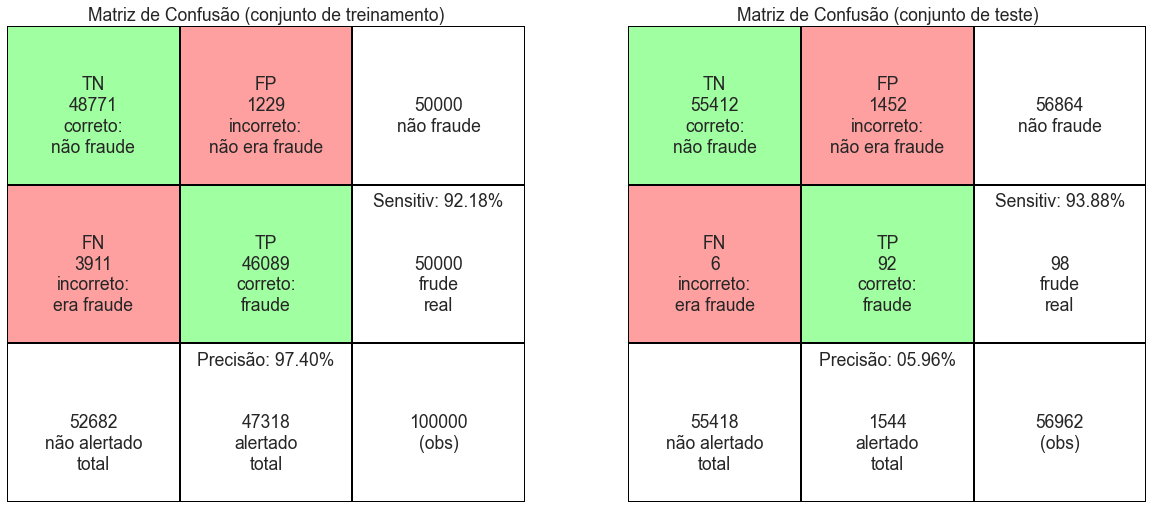

In [37]:
def bloco():
        
    import matplotlib
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    #from sklearn.metrics import roc_curve
    import seaborn as sns
    import pandas as pd
        
    Y_test_pred = model2.predict( X_test[ df_features ] )
    Y_train_pred = model2.predict( X_train[ df_features ] )

    from sklearn.metrics import classification_report
    
    print( 'Relatório de classificação para o conjunto de treinamento')
    print( classification_report( Y_train, Y_train_pred ) )
    
    print( 'Relatório de classificação para o conjunto de testes')
    print( classification_report( Y_test, Y_test_pred ) )      
    
    def matriz_confusao( fig, ax, Y, Y_pred, title ):

   

        
        class_names = ['Benigno','Maligno']

        confusion_mtx = pd.DataFrame( 
            columns=class_names,        
            data=confusion_matrix( Y, Y_pred )
        )    
        confusion_mtx['Total'] = confusion_mtx['Benigno'] + confusion_mtx['Maligno']
        confusion_mtx = confusion_mtx.append(confusion_mtx.sum(numeric_only=True), ignore_index=True)
        confusion_mtx = confusion_mtx.rename( index={ 0:'Benigno', 1:'Maligno', 2:'Total' } )

        fp = confusion_mtx.iloc[0,1] 
        fn = confusion_mtx.iloc[1,0]
        tn = confusion_mtx.iloc[0,0]
        tp = confusion_mtx.iloc[1,1] 

        acc       = (tp+tn)/(tp+tn+fp+fn)
        recall    = tp/(tp+fn)
        f1        = (2*acc*recall)/(acc+recall)

        fdr  = fp/(fp+tp)
        fnr  = fn/(fn+tp)

        tpr = tp/(fn+tp)
        ppv  = tp/(fp+tp)

        sns.set(font_scale=1.5)

        
        c = sns.heatmap([[2,1,0],[1,2,0],[0,0,0]], 
                        ax = ax,
                        annot=[
                            ['\n\nTN\n\ncorreto:\nnão fraude\n','\n\nFP\n\nincorreto:\nnão era fraude\n','\n\n\n\nnão fraude\n\n'],
                            ['\n\nFN\n\nincorreto:\nera fraude\n','\n\nTP\n\ncorreto:\nfraude\n',f'Sensitiv: {tpr*100.0:05.2f}%\n\n\n\nfrude\nreal\n'],
                            ['\n\n\n\nnão alertado\ntotal\n',f'Precisão: {ppv*100.0:05.2f}%\n\n\n\nalertado\ntotal\n','\n\n\n(obs)\n']], 
                        cbar=False, 
                        fmt='',
                        yticklabels=False,
                        xticklabels=False,
                        linewidths=2,
                        linecolor='#000000',
                        cmap=matplotlib.colors.ListedColormap(['#ffffff','#FFa0a0','#a0FFa0'])
                   )
        c = sns.heatmap(confusion_mtx,                     
                        ax = ax,
                        annot=True, 
                        fmt='g', 
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False, 
                        cmap=matplotlib.colors.ListedColormap(['#ffffff00']),
                        linewidths=2,                    
                        linecolor='#000000'
                   )

        #c.set(xlabel='Predicted',ylabel='True')
        c.set(title=title)
        #c.tick_params(right=True, bottom=True, labelright=True, labeltop=True,rotation=0)

        #c.set(xlabel='Predicted',ylabel='True')
        c.tick_params(right=False, bottom=False, labelright=False, labeltop=False,rotation=0)
        
        #print( f'      Accuracy={acc:05.2f}' )
        #print( f'       F Score={f1:05.2f}' )
        #print( f'   Sensitivity={tpr*100.0:05.2f}% of the real class was detected' )   
        #print( f'     Precision={ppv*100.0:05.2f}% of the predicted class was correct' )    

        #plt.text( s=f'Sensitividade:\n{tpr*100.0:05.2f}% of', x=2.05, y=1.25, size='small', color='#808080' )
        #plt.text( s=f'Precisão:\n{ppv*100.0:05.2f}% of', ha='right', x=1.95, y=2.25, size='small', color='#808080' )
        
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (21,9), dpi=70)
 
    matriz_confusao( fig, ax[0], Y_train, Y_train_pred, 'Matriz de Confusão (conjunto de treinamento)' ) 
    matriz_confusao( fig, ax[1], Y_test, Y_test_pred, 'Matriz de Confusão (conjunto de teste)' )   
    plt.show()            

bloco()


# Considerações Finais

* A comparação das matrizes de confusão de treino e teste acabam não tendo muito sentido devido a forma com que foi realizado o balanceamento. Como as proporções entre os registros da classe 0 e 1 entre as bases de treinamento e de teste não há como compara-los. De toda forma há indícios que houve um overfit pois o conjunto de treinamento chegou a quase 100% de precisão e sensibilidade. De toda forma no conjunto de teste o modelo reteve uma performance adequada.

* O modelo ensemble atingiu uma precisão muito maior e uma sensibilidade levemente menor quando comparados com a regressão logística que era um dos componentes do ensemble. 


# Referências

* [1]: https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/
* [2]: https://en.wikipedia.org/wiki/Confusion_matrix
* [3]: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
* [4]: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.htmlFinal 
* [5]: https://www.kaggle.com/mlg-ulb/creditcardfraud
* [6]: https://en.wikipedia.org/wiki/ISO_8583
* [7]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html





# Apêndice 1 - Revisão de conceitos

### PCA

A [transformação PCA][1] consiste em uma "redução de dimensionalidade" usualmente é utilizada para simplificar e reduzir o número de colunas de um dataset. 

Entre outras coisas, atributos fortemente correlacionados acabarão resumidos. Isto é feito plotando cada coluna original como um eixo e buscando linhas perpendiculares entre si que correspondam as direções de maiores variações dos dados. Tais linhas se tornarão os novos eixos e os dados serão projetados nestes novos eixos. 

Um efeito colateral da redução de dimensionalidade é difícil reverter tal transformação, mas ela mantém características suficientes dos dados originais para permitir muitos estudos serem efetuados, assim serve como uma forma de anonimizar a base. 

### Leiaute das transações de cartão de crédito.

[O leiaute ISO8583][2] é um padrão de mercado muito usado nas redes de cartão de débito e crédito em nível mundial e apresenta os tipos de campos que devem ser encontrados:  
* conta;
* código da loja;
* código da maquineta;
* tipo de loja;
* endereço da loja;
* tipo de senha;
* cartão utilizados;
* situação do terminal;
* etc

### StratifiedKFold Cross Validation

O [GridSearch][3] e o [StackingClassifier][6] tem opção para usar o [StratifiedKFold][4]. Em essência este médoto subdivide o conjunto de treinamento em fatias, usa [uma das fatias para validação e as demais fatias para treinamento][5], conforme ilustrado abaixo para um kfold com cv=4 (4 fatias).
      
     iteracao 1: V T T T  
     iteracao 2: T V T T
     iteracao 3: T T V T  
     iteracao 4: T T T V  
     
Esta é uma boa forma de trabalho pois permite usar 100% da base de treino sem perder um pequeno percentual para a validação. Isto é especialmente relevante para as bases desbalanceadas em que a classe de interesse usualmente tem poucas observações. 


[1]: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
[2]: https://en.wikipedia.org/wiki/ISO_8583
[3]: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
[4]: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
[5]: https://scikit-learn.org/stable/modules/cross_validation.html
[6]: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html


In [160]:
%%HTML 
<style> .jp-Cell { max-width: 700pt; margin-right: auto } h1 { margin-top: 60pt !IMPORTANT; } h2 { margin-top: 20pt; } </style>